<a href="https://colab.research.google.com/github/jacob-walker12/jacob-walker12.github.io/blob/main/notebooks/starter_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

bike = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

bike

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday
0,1/1/2011,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0
1,1/1/2011,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0
2,1/1/2011,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0
3,1/1/2011,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0
4,1/1/2011,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
112470,10/31/2023,19.0,241,594,10.2,10.2,0.4516,8.4,2,4,0,1
112471,10/31/2023,20.0,171,450,8.9,7.5,0.5268,9.3,1,4,0,1
112472,10/31/2023,21.0,176,402,7.7,6.4,0.5756,7.8,1,4,0,1
112473,10/31/2023,22.0,106,257,8.0,8.0,0.5604,0.0,1,4,0,1


In [48]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# -----------------------------
# Load + parse dates
# -----------------------------
bike['dteday'] = pd.to_datetime(bike['dteday'])

# Handy bounds (auto-adjust to your dataset)
min_day = bike['dteday'].min()
max_day = bike['dteday'].max()

# -----------------------------
# 1) COVID lockdown indicator (DC stay-at-home order period)
#   DC stay-at-home order effective 2020-04-01; extended through mid/late May 2020.
#   You can broaden this window if you mean "COVID restriction era" rather than strict stay-at-home.
# -----------------------------
covid_lockdown_ranges = [
    ('2020-04-01', '2020-05-29'),  # DC stay-at-home era (edit end date if your definition differs)
]

bike['covid_lockdown'] = 0
for start, end in covid_lockdown_ranges:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    bike.loc[(bike['dteday'] >= start) & (bike['dteday'] <= end), 'covid_lockdown'] = 1

# -----------------------------
# 2) Government shutdown indicator (US federal shutdowns affecting DC)
# -----------------------------
gov_shutdown_ranges = [
    ('2013-10-01', '2013-10-17'),  # 2013 shutdown
    ('2018-01-20', '2018-01-22'),  # 2018 shutdown
    ('2018-12-22', '2019-01-25'),  # 2018-2019 shutdown
]

bike['gov_shutdown'] = 0
for start, end in gov_shutdown_ranges:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    bike.loc[(bike['dteday'] >= start) & (bike['dteday'] <= end), 'gov_shutdown'] = 1

# -----------------------------
# 3) Big event indicator (EDIT these to match what *you* consider "big events")
#   Examples shown: major DC-centric events (inaugurations) + a couple of common big days.
# -----------------------------
big_event_ranges = [
    ('2013-01-18', '2013-01-22'),  # 2013 presidential inauguration weekend window
    ('2017-01-19', '2017-01-21'),  # 2017 inauguration window
    ('2021-01-19', '2021-01-21'),  # 2021 inauguration window
    ('2015-09-22', '2015-09-24'),  # example: Papal visit window (edit if desired)
    ('2020-06-01', '2020-06-02'),  # example: curfew/unrest peak window (edit if desired)
]

bike['big_event'] = 0
for start, end in big_event_ranges:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    bike.loc[(bike['dteday'] >= start) & (bike['dteday'] <= end), 'big_event'] = 1

# -----------------------------
# 4) Major holiday indicator
#   Strategy:
#   - If your dataset has a "holiday" column (0/1), keep it as a baseline
#   - Define "major" as: (holiday==1) AND also matches US federal holiday calendar
#     OR (explicitly listed major fixed-date holidays like Jul 4 / Dec 25 / Jan 1).
# -----------------------------
# US federal holidays within data range
cal = USFederalHolidayCalendar()
federal_holidays = cal.holidays(start=min_day, end=max_day)

# Fixed-date major holidays (commonly treated as major regardless of calendar nuances)
fixed_major_md = {(1, 1), (7, 4), (12, 25)}  # New Year, Independence Day, Christmas
fixed_major = bike['dteday'].apply(lambda d: (d.month, d.day) in fixed_major_md)

# If your dataset has 'holiday', incorporate it; otherwise just use calendar logic
if 'holiday' in bike.columns:
    bike['major_holiday'] = (
        ((bike['holiday'] == 1) & (bike['dteday'].isin(federal_holidays) | fixed_major))
        | fixed_major
    ).astype(int)
else:
    bike['major_holiday'] = (bike['dteday'].isin(federal_holidays) | fixed_major).astype(int)

# -----------------------------
# Quick sanity check
# -----------------------------
cols = ['dteday', 'covid_lockdown', 'gov_shutdown', 'big_event', 'major_holiday']
print(bike[cols].head(10))
print("\nCounts:\n", bike[cols[1:]].sum())
print(bike)

      dteday  covid_lockdown  gov_shutdown  big_event  major_holiday
0 2011-01-01               0             0          0              1
1 2011-01-01               0             0          0              1
2 2011-01-01               0             0          0              1
3 2011-01-01               0             0          0              1
4 2011-01-01               0             0          0              1
5 2011-01-01               0             0          0              1
6 2011-01-01               0             0          0              1
7 2011-01-01               0             0          0              1
8 2011-01-01               0             0          0              1
9 2011-01-01               0             0          0              1

Counts:
 covid_lockdown    1416
gov_shutdown      1320
big_event          384
major_holiday     3384
dtype: int64
           dteday    hr  casual  registered  temp_c  feels_like_c     hum  \
0      2011-01-01   0.0       3          13     3

In [49]:
bike['dteday'] = pd.to_datetime(bike['dteday'])
bike['date'] = bike['dteday'].dt.date

# print(bike[['dteday', 'date']].head())

bike['dteday'] = pd.to_datetime(bike['dteday'])
bike['date'] = bike['dteday'].dt.date

# print(bike[['dteday', 'date']].head())

bike = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

bike['dteday'] = pd.to_datetime(bike['dteday'])
bike['date'] = bike['dteday'].dt.date

# print(bike[['dteday', 'date']].head())

daily_bike_data = bike.groupby('date').agg(
    casual=('casual', 'sum'),
    registered=('registered', 'sum'),
    temp_c=('temp_c', 'mean'),
    feels_like_c=('feels_like_c', 'mean'),
    hum=('hum', 'mean'),
    windspeed=('windspeed', 'mean'),
    weathersit=('weathersit', 'first'),
    season=('season', 'first'),
    holiday=('holiday', 'first'),
    workingday=('workingday', 'first')
).reset_index()

daily_bike_data['day_of_week'] = pd.to_datetime(daily_bike_data['date']).dt.day_name()

print(daily_bike_data.head())

         date  casual  registered    temp_c  feels_like_c       hum  \
0  2011-01-01     330         629  8.137500      7.970833  0.823567   
1  2011-01-02     130         651  9.204167      7.429167  0.704825   
2  2011-01-03     120        1181  0.558333     -3.729167  0.443213   
3  2011-01-04     107        1429  0.550000     -2.350000  0.603488   
4  2011-01-05      82        1489  2.237500     -0.891667  0.439533   

   windspeed  weathersit  season  holiday  workingday day_of_week  
0  10.754167           1       1        0           0    Saturday  
1  16.783333           2       1        0           0      Sunday  
2  16.750000           1       1        0           1      Monday  
3  10.095833           1       1        0           1     Tuesday  
4  12.700000           1       1        0           1   Wednesday  


In [50]:
bike.head()

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,date
0,2011-01-01,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0,2011-01-01
1,2011-01-01,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0,2011-01-01
2,2011-01-01,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0,2011-01-01
3,2011-01-01,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0,2011-01-01
4,2011-01-01,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0,2011-01-01


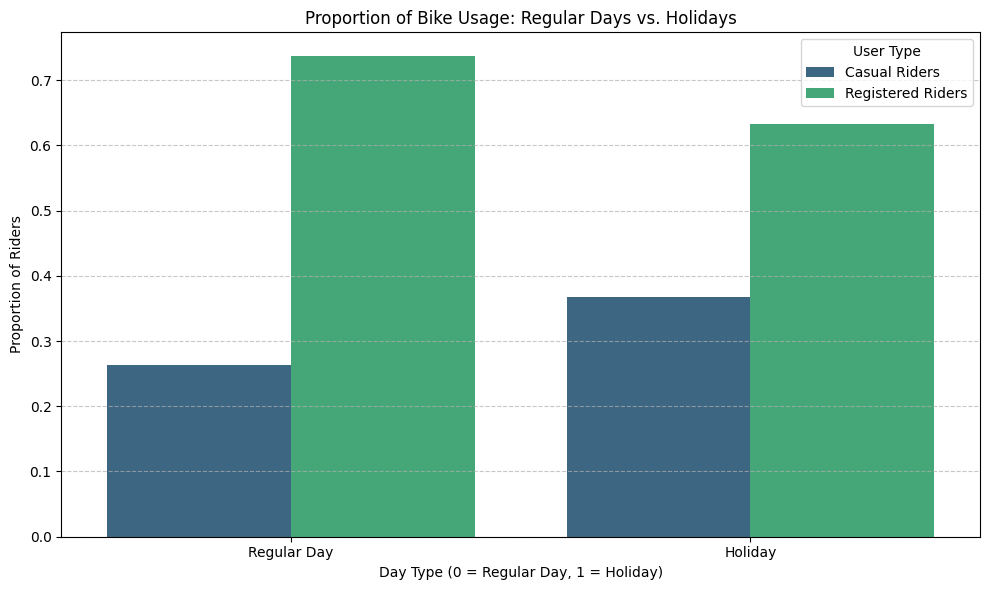

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by holiday and sum casual and registered bike usage
holiday_bike_usage = daily_bike_data.groupby('holiday')[['casual', 'registered']].sum().reset_index()

# Calculate total riders for each holiday category
holiday_bike_usage['total'] = holiday_bike_usage['casual'] + holiday_bike_usage['registered']

# Calculate proportions
holiday_bike_usage['casual_proportion'] = holiday_bike_usage['casual'] / holiday_bike_usage['total']
holiday_bike_usage['registered_proportion'] = holiday_bike_usage['registered'] / holiday_bike_usage['total']

# Melt the DataFrame for easier plotting with seaborn, now with proportions
holiday_bike_usage_melted = holiday_bike_usage.melt(id_vars='holiday', value_vars=['casual_proportion', 'registered_proportion'], var_name='user_type', value_name='proportion_of_riders')

# Rename user_type for better legend labels
holiday_bike_usage_melted['user_type'] = holiday_bike_usage_melted['user_type'].replace({
    'casual_proportion': 'Casual Riders',
    'registered_proportion': 'Registered Riders'
})

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='proportion_of_riders', hue='user_type', data=holiday_bike_usage_melted, palette='viridis')

# Customize the plot
plt.title('Proportion of Bike Usage: Regular Days vs. Holidays')
plt.xlabel('Day Type (0 = Regular Day, 1 = Holiday)')
plt.ylabel('Proportion of Riders')
plt.xticks(ticks=[0, 1], labels=['Regular Day', 'Holiday'])
plt.legend(title='User Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This bar chart visually compares the total number of casual and registered bike riders on regular days versus holidays. You can see how the usage patterns differ between these two categories.

# Task
Add a 'total_riders' column to the `daily_bike_data` DataFrame by summing 'casual' and 'registered' users, then create a combined bar and line chart showing daily total riders as bars, with overlaid lines for casual and registered users, and finally summarize the observed trends in bike usage.

## Calculate Total Riders

### Subtask:
Add a 'total_riders' column to the `daily_bike_data` DataFrame by summing the 'casual' and 'registered' columns. This will be used for the bar chart.


**Reasoning**:
To complete the subtask, I will add a new column 'total_riders' to the `daily_bike_data` DataFrame by summing the 'casual' and 'registered' columns. Then, I will display the head of the DataFrame to verify the new column.



In [52]:
daily_bike_data['total_riders'] = daily_bike_data['casual'] + daily_bike_data['registered']

print(daily_bike_data.head())

         date  casual  registered    temp_c  feels_like_c       hum  \
0  2011-01-01     330         629  8.137500      7.970833  0.823567   
1  2011-01-02     130         651  9.204167      7.429167  0.704825   
2  2011-01-03     120        1181  0.558333     -3.729167  0.443213   
3  2011-01-04     107        1429  0.550000     -2.350000  0.603488   
4  2011-01-05      82        1489  2.237500     -0.891667  0.439533   

   windspeed  weathersit  season  holiday  workingday day_of_week  \
0  10.754167           1       1        0           0    Saturday   
1  16.783333           2       1        0           0      Sunday   
2  16.750000           1       1        0           1      Monday   
3  10.095833           1       1        0           1     Tuesday   
4  12.700000           1       1        0           1   Wednesday   

   total_riders  
0           959  
1           781  
2          1301  
3          1536  
4          1571  


## Create Combined Bar and Line Chart

### Subtask:
Generate a plot where bars represent the 'total_riders' from `daily_bike_data` for each day, and overlaid lines show the 'casual' users (green) and 'registered' users (blue) over the same period. Ensure proper labeling for axes and a title for the chart.


**Reasoning**:
I need to generate a combined bar and line chart as described in the subtask. This involves creating a bar plot for total riders and overlaying line plots for casual and registered riders on a secondary y-axis. I will use `matplotlib.pyplot` and `seaborn` to achieve this, ensuring all labels, titles, and legends are correctly placed.



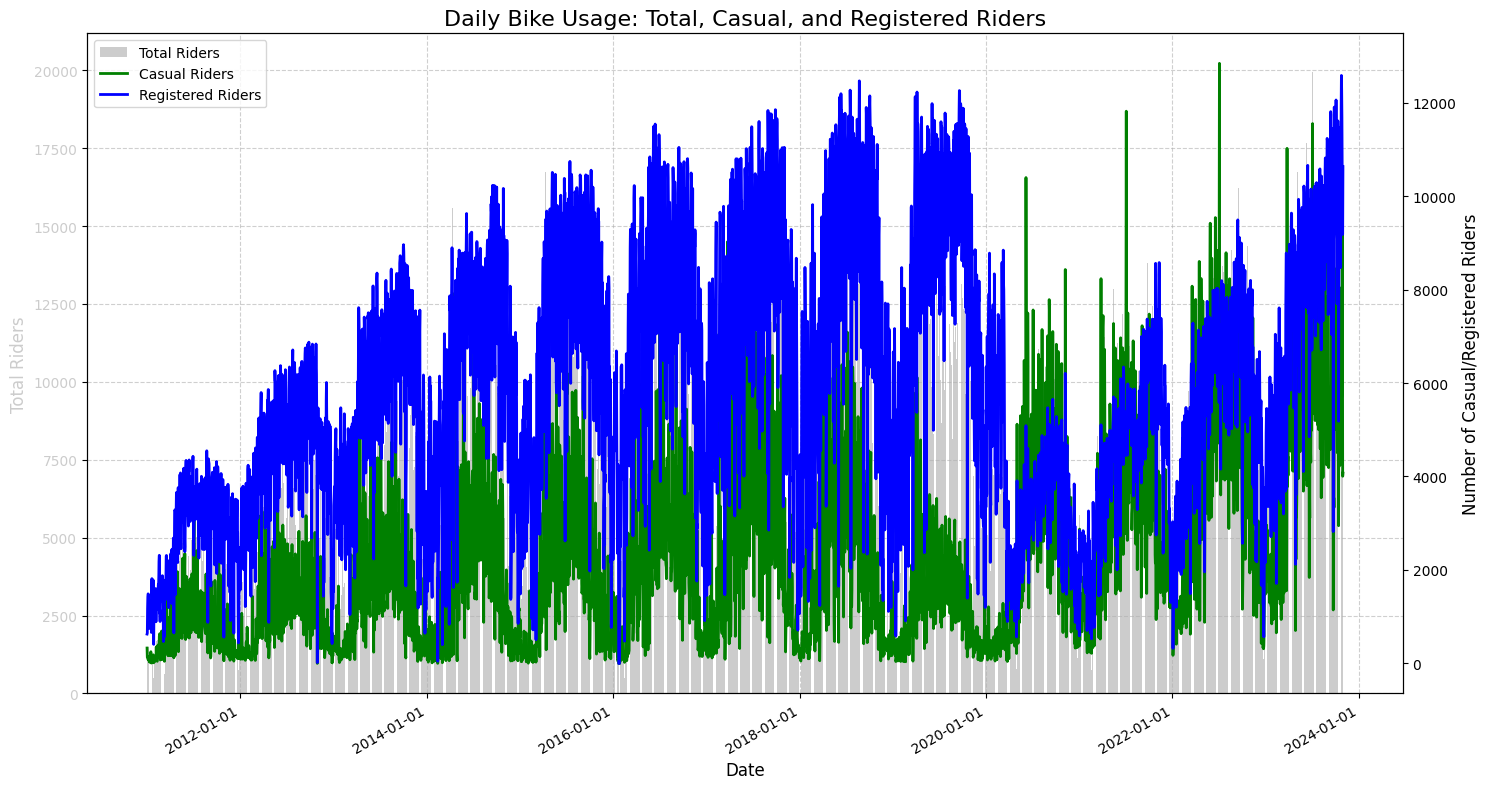

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format for proper plotting
daily_bike_data['date'] = pd.to_datetime(daily_bike_data['date'])

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 8))

# Convert dates to numerical format so both bar and line plots share the same continuous date axis
dates_numeric = mdates.date2num(daily_bike_data['date'])

# Plot total_riders as a bar chart on ax1 using numerical dates
bar_width = 0.8
ax1.bar(dates_numeric, daily_bike_data['total_riders'], width=bar_width, color='#cccccc', label='Total Riders', align='center')

# Create a second y-axis that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot casual riders as a green line on ax2
ax2.plot(dates_numeric, daily_bike_data['casual'], color='green', label='Casual Riders', linewidth=2)

# Plot registered riders as a blue line on ax2
ax2.plot(dates_numeric, daily_bike_data['registered'], color='blue', label='Registered Riders', linewidth=2)

# Set the title of the chart
plt.title('Daily Bike Usage: Total, Casual, and Registered Riders', fontsize=16)

# Set x-axis label for ax1
ax1.set_xlabel('Date', fontsize=12)

# Set y-axis label for ax1
ax1.set_ylabel('Total Riders', color='#cccccc', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#cccccc')

# Set y-axis label for ax2
ax2.set_ylabel('Number of Casual/Registered Riders', color='black', fontsize=12)

# Format the x-axis to display dates properly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize=10)

# Rotate x-axis labels if they overlap to improve readability
fig.autofmt_xdate()

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code failed because `sns.barplot` likely coerced the 'date' column into a categorical type for the x-axis, which then caused a `TypeError` when `ax2.plot` tried to interpret the same 'date' column as a datetime object for plotting lines. To fix this, I will use `ax1.bar` instead of `sns.barplot` to plot the total riders, using the numerical representation of dates for the x-axis. This ensures that the x-axis is treated as a continuous datetime scale, allowing the line plots on `ax2` to render correctly without conflicts.



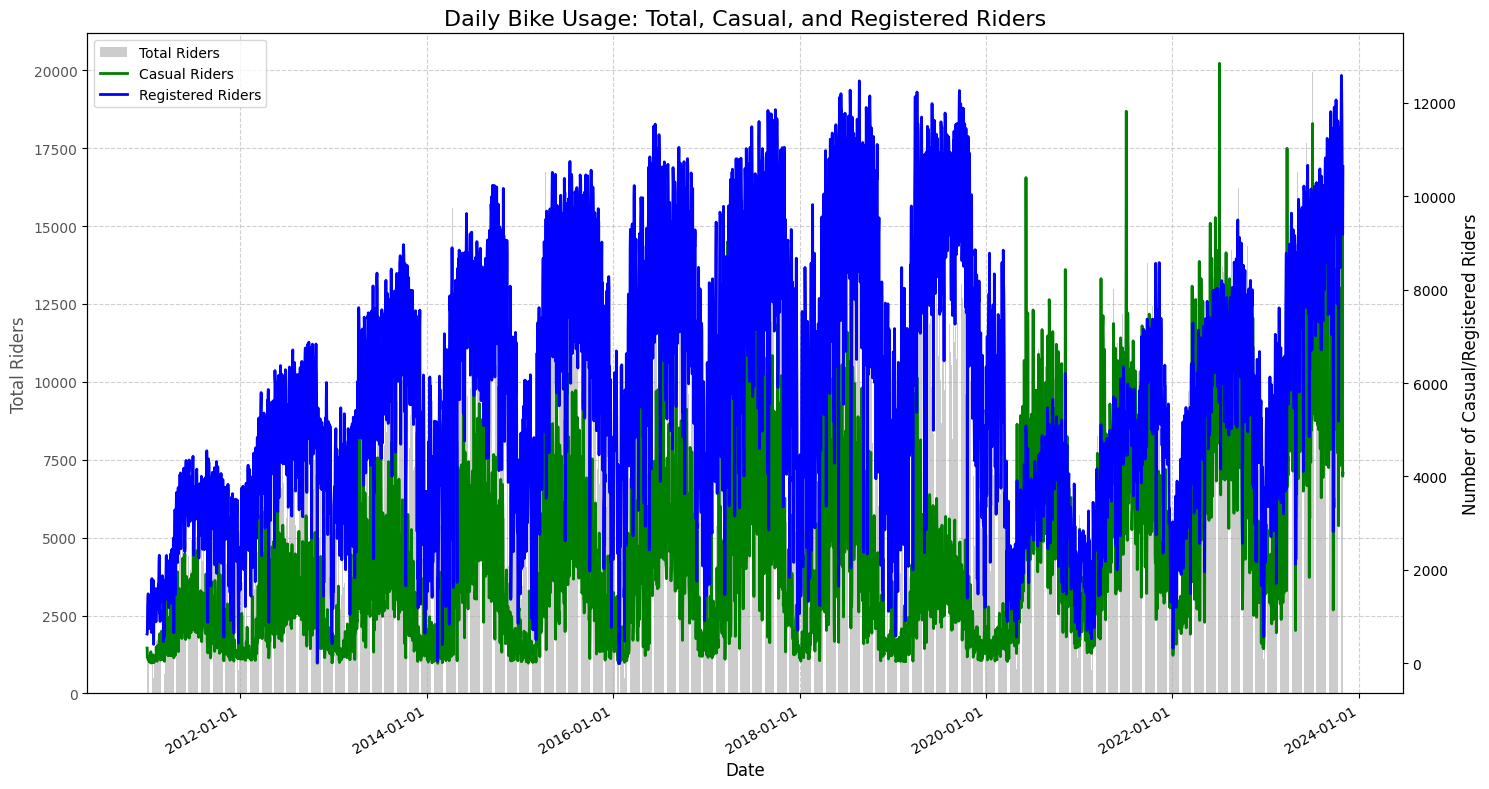

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format for proper plotting
daily_bike_data['date'] = pd.to_datetime(daily_bike_data['date'])

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 8))

# Convert dates to numerical format for plotting with plt.bar and plt.plot
# This ensures a continuous date axis consistent across both axes
dates_numeric = mdates.date2num(daily_bike_data['date'])

# Plot total_riders as a bar chart on ax1 using numerical dates
# We need to set the width of the bars appropriately for daily data
bar_width = 0.8 # Adjust as needed
ax1.bar(dates_numeric, daily_bike_data['total_riders'], width=bar_width, color='#cccccc', label='Total Riders', align='center')

# Create a second y-axis that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot casual riders as a green line on ax2 using numerical dates
ax2.plot(dates_numeric, daily_bike_data['casual'], color='green', label='Casual Riders', linewidth=2)

# Plot registered riders as a blue line on ax2 using numerical dates
ax2.plot(dates_numeric, daily_bike_data['registered'], color='blue', label='Registered Riders', linewidth=2)

# Set the title of the chart
plt.title('Daily Bike Usage: Total, Casual, and Registered Riders', fontsize=16)

# Set x-axis label for ax1
ax1.set_xlabel('Date', fontsize=12)

# Set y-axis label for ax1
ax1.set_ylabel('Total Riders', color='#555555', fontsize=12) # Adjusted color for visibility
ax1.tick_params(axis='y', labelcolor='#555555')

# Set y-axis label for ax2
ax2.set_ylabel('Number of Casual/Registered Riders', color='black', fontsize=12)

# Format the x-axis to display dates properly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize=10)

# Rotate x-axis labels if they overlap to improve readability
fig.autofmt_xdate()

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the insights observed from the combined bar and line chart, highlighting trends in casual, registered, and total bike usage over time.


## Summary:

### Q&A
The combined bar and line chart reveals distinct trends in casual, registered, and total bike usage over time. Registered users consistently form the majority of riders and show a much higher usage volume compared to casual users. Both casual and registered riders exhibit a clear seasonal pattern, with usage generally lower in colder months (e.g., early 2011) and significantly higher during warmer periods. Total ridership, driven primarily by registered users, mirrors this seasonal trend.

### Data Analysis Key Findings
*   A `total_riders` column was successfully added to the `daily_bike_data` DataFrame by summing 'casual' and 'registered' users. For example, on 2011-01-01, there were 330 casual and 629 registered riders, totaling 959 riders.
*   The generated chart clearly illustrates that `registered` riders (`blue line`) significantly outnumber `casual` riders (`green line`) throughout the observed period.
*   Both `casual` and `registered` rider numbers, and consequently `total_riders` (`grey bars`), demonstrate a strong seasonal pattern, with usage peaking during warmer months and declining during colder periods.
*   The `total_riders` bar height closely follows the `registered` riders line, indicating that registered users are the primary drivers of overall daily bike usage.

### Insights or Next Steps
*   **Targeted Marketing Opportunities:** Given the dominance of registered users, efforts could be focused on retaining and expanding this group through loyalty programs or incentives. For casual users, understanding what barriers prevent them from registering could unlock growth.
*   **Seasonal Operational Adjustments:** The clear seasonal trend suggests that resource allocation (e.g., bike availability, maintenance, staffing) could be optimized to match demand fluctuations, with higher capacity planned for peak seasons and reduced operations during off-peak times.


# Task
Prepare the `bike` DataFrame for hourly analysis by converting the 'dteday' column to datetime objects (if not already done), extracting the 'day_of_week' from 'dteday', and then aggregating 'casual' and 'registered' bike usage by 'day_of_week' and 'hr' to summarize total usage for each hour of each day.

## Prepare Data for Hourly Analysis

### Subtask:
Convert the 'dteday' column in the `bike` DataFrame to datetime objects, then extract the 'day_of_week' to enable hourly and daily analysis.


**Reasoning**:
First, I'll convert the 'dteday' column to datetime objects to ensure consistency and then extract the 'day_of_week' to a new column as instructed. Finally, I will display the head of the DataFrame to verify the changes.



In [55]:
bike['dteday'] = pd.to_datetime(bike['dteday'])
bike['day_of_week'] = bike['dteday'].dt.day_name()

print(bike.head())

      dteday   hr  casual  registered  temp_c  feels_like_c     hum  \
0 2011-01-01  0.0       3          13     3.0           3.0  0.7957   
1 2011-01-01  1.0       8          30     1.7           1.7  0.8272   
2 2011-01-01  2.0       5          26     1.9           1.9  0.8157   
3 2011-01-01  3.0       3           9     2.5           2.5  0.7831   
4 2011-01-01  4.0       0           1     2.0           2.0  0.8075   

   windspeed  weathersit  season  holiday  workingday        date day_of_week  
0        0.8           1       1        0           0  2011-01-01    Saturday  
1        0.8           1       1        0           0  2011-01-01    Saturday  
2        1.1           1       1        0           0  2011-01-01    Saturday  
3        0.8           1       1        0           0  2011-01-01    Saturday  
4        1.1           1       1        0           0  2011-01-01    Saturday  


## Aggregate Hourly Bike Usage

### Subtask:
Group the `bike` DataFrame by 'day_of_week' and 'hr', and then sum the 'casual' and 'registered' columns to get the total usage for each hour of each day of the week.


**Reasoning**:
To complete the subtask, I will group the `bike` DataFrame by 'day_of_week' and 'hr', calculate the sum of 'casual' and 'registered' riders, reset the index, and store the result in `hourly_bike_usage`.



In [56]:
hourly_bike_usage = bike.groupby(['day_of_week', 'hr']).agg(
    casual=('casual', 'sum'),
    registered=('registered', 'sum')
).reset_index()

print(hourly_bike_usage.head())

  day_of_week   hr  casual  registered
0      Friday  0.0   13673       34099
1      Friday  1.0    7443       16459
2      Friday  2.0    4240        8396
3      Friday  3.0    1993        4040
4      Friday  4.0    1891        6254


## Generate Hourly Bike Usage Line Charts

### Subtask:
Create line charts showing casual and registered bike usage across hours, faceted by each day of the week, with different colored lines for casual and registered users. Ensure proper labeling for axes and a title for the chart.


**Reasoning**:
To create line charts showing casual and registered bike usage faceted by day of the week, I need to first prepare the data by melting the `hourly_bike_usage` DataFrame into a long format suitable for `seaborn.relplot`. Then, I will generate the plot with the specified parameters.



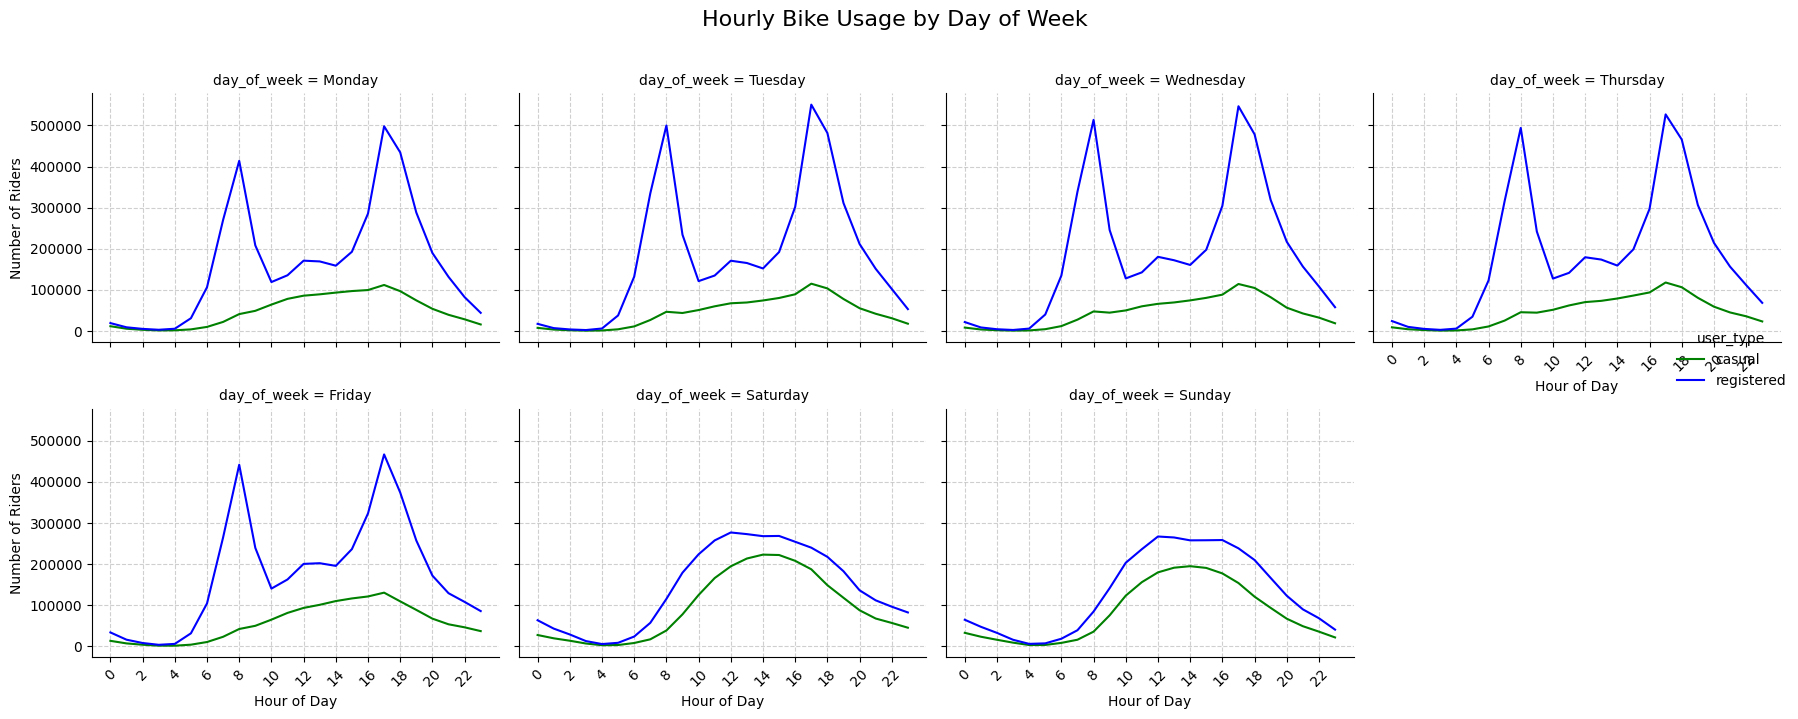

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order of days for consistent plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'hr' to int type to remove '.0'
hourly_bike_usage['hr'] = hourly_bike_usage['hr'].astype(int)

# Melt the DataFrame to long format for plotting casual and registered as separate lines
hourly_bike_usage_melted = hourly_bike_usage.melt(
    id_vars=['day_of_week', 'hr'],
    value_vars=['casual', 'registered'],
    var_name='user_type',
    value_name='total_riders'
)

# Create the relplot
g = sns.relplot(
    data=hourly_bike_usage_melted,
    x='hr',
    y='total_riders',
    kind='line',
    col='day_of_week',
    col_order=day_order,
    hue='user_type',
    col_wrap=4,
    height=3.5,
    aspect=1.2,
    palette={'casual': 'green', 'registered': 'blue'}
)

# Set descriptive titles and labels
g.fig.suptitle('Hourly Bike Usage by Day of Week', y=1.02, fontsize=16)
g.set_axis_labels('Hour of Day', 'Number of Riders')

# Adjust x-axis ticks to show all hours clearly
for ax in g.axes.flat:
    ax.set_xticks(range(0, 24, 2)) # Show every other hour
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()
plt.show()

## Summarize Hourly Bike Usage Trends

### Subtask:
Analyze and summarize the observed trends in casual and registered bike usage across different hours of the day and days of the week from the generated line charts.


## Summary:

### Q&A
The analysis revealed distinct hourly bike usage trends for both casual and registered users across different days of the week. Registered users predominantly exhibit commuting patterns with morning and evening peaks on weekdays, while casual users show leisure-oriented usage with a broader midday to afternoon peak, particularly strong on weekends.

### Data Analysis Key Findings
*   The `bike` DataFrame was successfully prepared by converting the `dteday` column to datetime objects and extracting the `day_of_week` to facilitate hourly and daily usage analysis.
*   Hourly bike usage was aggregated by summing `casual` and `registered` riders for each hour of each day, creating a comprehensive `hourly_bike_usage` dataset. For example, on a Friday at hour 0, there were 13673 casual riders and 34099 registered riders.
*   The generated line charts revealed that **registered users** typically display a bimodal usage pattern on weekdays, with prominent peaks during morning (e.g., 7-9 AM) and evening (e.g., 5-7 PM) commuting hours. On weekends, their usage is generally lower and shows a single, broader peak, often in the afternoon.
*   **Casual users** exhibit a more leisure-oriented unimodal pattern, with usage peaking broadly from midday to afternoon (e.g., 10 AM - 4 PM) on both weekdays and weekends. Their overall usage tends to be higher or more comparable to registered users during peak weekend leisure hours.
*   Overall, bike usage for both casual and registered riders is significantly lower during early morning hours (e.g., 1 AM - 5 AM) across all days of the week.

### Insights or Next Steps
*   The observed distinct usage patterns between casual and registered riders and across weekdays/weekends can inform demand-side management strategies, such as dynamic pricing or promotional campaigns tailored to specific user types and times.
*   Further analysis could explore the impact of weather conditions, holidays, or special events on these hourly and daily usage trends to provide a more complete picture of demand drivers.


In [58]:
bike


,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,date,day_of_week
0,2011-01-01,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0,2011-01-01,Saturday
1,2011-01-01,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0,2011-01-01,Saturday
2,2011-01-01,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0,2011-01-01,Saturday
3,2011-01-01,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0,2011-01-01,Saturday
4,2011-01-01,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0,2011-01-01,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112470,2023-10-31,19.0,241,594,10.2,10.2,0.4516,8.4,2,4,0,1,2023-10-31,Tuesday
112471,2023-10-31,20.0,171,450,8.9,7.5,0.5268,9.3,1,4,0,1,2023-10-31,Tuesday
112472,2023-10-31,21.0,176,402,7.7,6.4,0.5756,7.8,1,4,0,1,2023-10-31,Tuesday
112473,2023-10-31,22.0,106,257,8.0,8.0,0.5604,0.0,1,4,0,1,2023-10-31,Tuesday


In [59]:
from google.colab import files
from pandas.tseries.holiday import USFederalHolidayCalendar

# ── Re-add all engineered features ──────────────────────────────────────

bike['dteday'] = pd.to_datetime(bike['dteday'])
min_day = bike['dteday'].min()
max_day = bike['dteday'].max()

# 1) covid_lockdown
covid_lockdown_ranges = [('2020-04-01', '2021-07-25')]
bike['covid_lockdown'] = 0
for start, end in covid_lockdown_ranges:
    bike.loc[(bike['dteday'] >= pd.to_datetime(start)) & (bike['dteday'] <= pd.to_datetime(end)), 'covid_lockdown'] = 1

# 2) gov_shutdown
gov_shutdown_ranges = [('2013-10-01','2013-10-17'), ('2018-01-20','2018-01-22'), ('2018-12-22','2019-01-25')]
bike['gov_shutdown'] = 0
for start, end in gov_shutdown_ranges:
    bike.loc[(bike['dteday'] >= pd.to_datetime(start)) & (bike['dteday'] <= pd.to_datetime(end)), 'gov_shutdown'] = 1

# 3) big_event
big_event_ranges = [
    # Presidential Inaugurations
    ('2013-01-18', '2013-01-22'), ('2017-01-19', '2017-01-21'), ('2021-01-19', '2021-01-21'),
    # State of the Union / Joint Session Addresses
    ('2011-01-25', '2011-01-25'), ('2012-01-24', '2012-01-24'), ('2013-02-12', '2013-02-12'),
    ('2014-01-28', '2014-01-28'), ('2015-01-20', '2015-01-20'), ('2016-01-12', '2016-01-12'),
    ('2017-02-28', '2017-02-28'), ('2018-01-30', '2018-01-30'), ('2019-02-05', '2019-02-05'),
    ('2020-02-04', '2020-02-04'), ('2021-04-28', '2021-04-28'), ('2022-03-01', '2022-03-01'),
    ('2023-02-07', '2023-02-07'),
    # Major Marches & Protests
    ('2017-01-21', '2017-01-21'), ('2018-01-20', '2018-01-20'), ('2019-01-19', '2019-01-19'), ('2020-01-18', '2020-01-18'),
    ('2018-03-24', '2018-03-24'), ('2017-04-22', '2017-04-22'),
    ('2011-01-22', '2011-01-22'), ('2012-01-23', '2012-01-23'), ('2013-01-25', '2013-01-25'),
    ('2014-01-22', '2014-01-22'), ('2015-01-22', '2015-01-22'), ('2016-01-22', '2016-01-22'),
    ('2017-01-27', '2017-01-27'), ('2018-01-19', '2018-01-19'), ('2019-01-18', '2019-01-18'),
    ('2020-01-24', '2020-01-24'), ('2022-01-21', '2022-01-21'), ('2023-01-20', '2023-01-20'),
    ('2020-05-29', '2020-06-07'), ('2021-01-06', '2021-01-06'),
    # Other Major DC Events
    ('2015-09-22', '2015-09-24'), ('2014-11-11', '2014-11-11'),
    ('2017-04-29', '2017-04-29'), ('2018-08-12', '2018-08-12'),
]
bike['big_event'] = 0
for start, end in big_event_ranges:
    bike.loc[(bike['dteday'] >= pd.to_datetime(start)) & (bike['dteday'] <= pd.to_datetime(end)), 'big_event'] = 1

# 4) major_holiday
cal = USFederalHolidayCalendar()
federal_holidays = cal.holidays(start=min_day, end=max_day)
fixed_major_md = {(1,1),(7,4),(12,25)}
fixed_major = bike['dteday'].apply(lambda d: (d.month, d.day) in fixed_major_md)
bike['major_holiday'] = (((bike['holiday'] == 1) & (bike['dteday'].isin(federal_holidays) | fixed_major)) | fixed_major).astype(int)

# 5) date and day_of_week
bike['date'] = bike['dteday'].dt.date
bike['day_of_week'] = bike['dteday'].dt.day_name()

# 6) weather_emergency (NEW)
# Blizzards, hurricanes, derechos, and other major weather events in DC (2011-2023)
weather_emergency_ranges = [
    # --- Major Blizzards / Snowstorms ---
    # Jan 2011 snowstorm (~5" at DCA, widespread disruption)
    ('2011-01-26', '2011-01-27'),
    # Feb 2014 snowstorm (~6" + ice, 2nd major storm of brutal winter)
    ('2014-02-12', '2014-02-13'),
    # Mar 2014 snowstorm (continuation of brutal 2013-14 winter)
    ('2014-03-17', '2014-03-17'),
    # Jan 2016 Blizzard Jonas / Snowzilla (17.8" at DCA - historic, state of emergency)
    ('2016-01-22', '2016-01-24'),
    # Jan 2019 major snowstorm (8.3" at DCA)
    ('2019-01-13', '2019-01-14'),
    # Feb 2019 snowstorm
    ('2019-02-11', '2019-02-12'),
    # Jan 2022 snowstorm (6.9" at DCA)
    ('2022-01-03', '2022-01-04'),
    # Jan 2016 also had a second smaller storm
    ('2016-02-15', '2016-02-16'),
    # Dec 2020 snowstorm
    ('2020-12-16', '2020-12-17'),
    # Feb 2015 back-to-back snowstorms (Juno aftermath + multiple storms)
    ('2015-02-16', '2015-02-17'),
    ('2015-03-05', '2015-03-06'),
    # Feb 2013 Nemo (DC fringe, significant snow)
    ('2013-02-08', '2013-02-09'),
    # --- Hurricanes & Tropical Storms ---
    # Hurricane Irene - heavy rain, flooding, wind damage in DC
    ('2011-08-27', '2011-08-28'),
    # Hurricane Sandy - historic storm, extensive DC-area damage, state of emergency
    ('2012-10-28', '2012-10-30'),
    # Tropical Storm Isaias - power outages, downed trees across DC metro
    ('2020-08-04', '2020-08-04'),
    # --- Derecho & Extreme Wind Events ---
    # Derecho of June 29, 2012 - 70+ mph gusts, 1M+ without power, 22 deaths
    ('2012-06-29', '2012-06-29'),
    # --- Earthquake ---
    # 5.8 magnitude Virginia earthquake felt strongly throughout DC
    ('2011-08-23', '2011-08-23'),
]
bike['weather_emergency'] = 0
for start, end in weather_emergency_ranges:
    bike.loc[(bike['dteday'] >= pd.to_datetime(start)) & (bike['dteday'] <= pd.to_datetime(end)), 'weather_emergency'] = 1

# ── Sanity check
print('weather_emergency flagged dates:')
print(bike[bike['weather_emergency'] == 1][['dteday']].drop_duplicates().sort_values('dteday').to_string())
print(f'\nTotal weather_emergency rows: {bike["weather_emergency"].sum()}')
print(f'Total columns: {bike.shape[1]}')

# ── Export
bike.to_csv('bikes_with_features.csv', index=False)
print('\nColumns included:', list(bike.columns))
print(f'Shape: {bike.shape}')
print('CSV saved as bikes_with_features.csv')
files.download('bikes_with_features.csv')

weather_emergency flagged dates:
          dteday
600   2011-01-26
624   2011-01-27
5615  2011-08-23
5711  2011-08-27
5735  2011-08-28
13078 2012-06-29
15982 2012-10-28
16006 2012-10-29
16030 2012-10-30
18454 2013-02-08
18478 2013-02-09
27309 2014-02-12
27333 2014-02-13
28100 2014-03-17
36164 2015-02-16
36188 2015-02-17
36572 2015-03-05
36596 2015-03-06
44323 2016-01-22
44347 2016-01-23
44371 2016-01-24
44899 2016-02-15
44923 2016-02-16
70408 2019-01-13
70432 2019-01-14
71104 2019-02-11
71128 2019-02-12
84062 2020-08-04
87278 2020-12-16
87302 2020-12-17
96469 2022-01-03
96493 2022-01-04

Total weather_emergency rows: 768
Total columns: 19

Columns included: ['dteday', 'hr', 'casual', 'registered', 'temp_c', 'feels_like_c', 'hum', 'windspeed', 'weathersit', 'season', 'holiday', 'workingday', 'date', 'day_of_week', 'covid_lockdown', 'gov_shutdown', 'big_event', 'major_holiday', 'weather_emergency']
Shape: (112475, 19)
CSV saved as bikes_with_features.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train:      78,732 rows
Validation: 16,871 rows
Test:       16,872 rows


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 51,585 (201.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 152501.0000 - mae: 279.4078 - val_loss: 74134.0547 - val_mae: 200.1946
Epoch 2/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 76752.6797 - mae: 202.9598 - val_loss: 65868.1094 - val_mae: 183.6300
Epoch 3/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 68735.0859 - mae: 187.1489 - val_loss: 55513.5938 - val_mae: 161.4163
Epoch 4/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60470.6328 - mae: 169.7561 - val_loss: 49300.6875 - val_mae: 146.9074
Epoch 5/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54761.6719 - mae: 158.1217 - val_loss: 46864.2188 - val_mae: 139.5348
Epoch 6/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51921.9805 - mae: 152.6435 - val_loss: 45619.4570 - val_mae: 136.9275
Epoch 7/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49876.2031 - mae: 148.5215 - val_loss: 44276.8594 - val_mae: 135.8661
Epoch 8/200
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48813.0430 - mae: 14

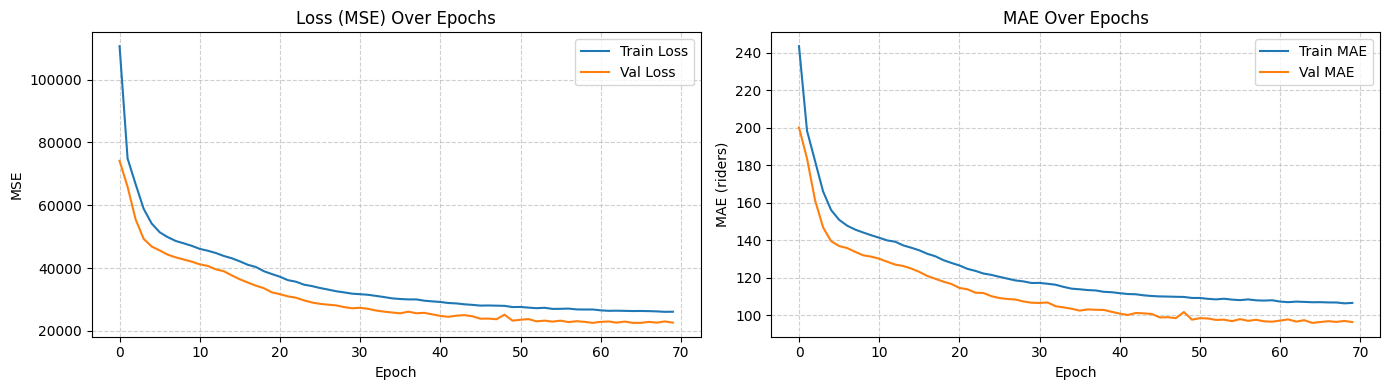

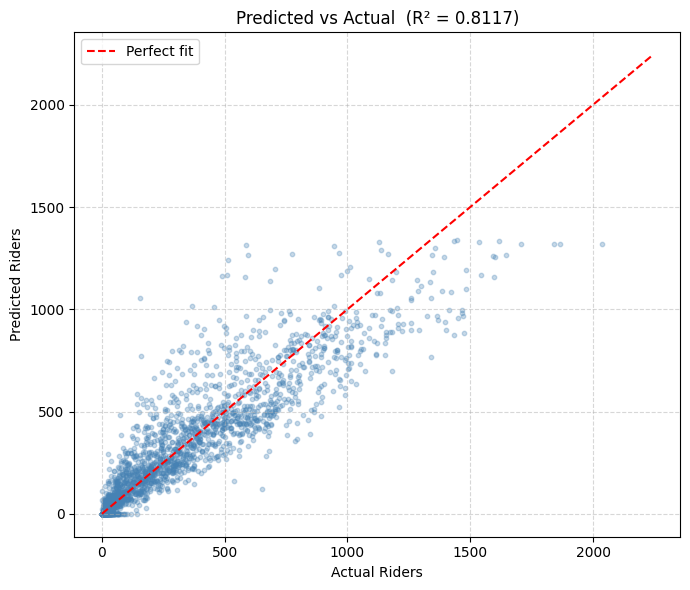


Done.


In [60]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ── 1. Prepare features & target ──────────────────────────────────────────

# Target: total hourly ridership
bike['total_riders'] = bike['casual'] + bike['registered']

# Encode day_of_week as integer (Monday=0 ... Sunday=6)
day_map = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,
           'Friday':4,'Saturday':5,'Sunday':6}
bike['day_of_week_num'] = bike['day_of_week'].map(day_map)

# Feature columns
feature_cols = [
    'hr',            # hour of day
    'temp_c',        # temperature
    'feels_like_c',  # feels-like temperature
    'hum',           # humidity
    'windspeed',     # wind speed
    'weathersit',    # weather situation code
    'season',        # season (1-4)
    'holiday',       # public holiday flag
    'workingday',    # working day flag
    'day_of_week_num',  # day of week (0-6)
    'covid_lockdown',   # COVID lockdown period
    'gov_shutdown',     # government shutdown period
    'big_event',        # major DC events
    'major_holiday',    # major holiday
    'weather_emergency' # blizzards, hurricanes, etc.
]

X = bike[feature_cols].values
y = bike['total_riders'].values

# ── 2. Scale features ─────────────────────────────────────────────────────
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ── 3. Train / Validation / Test split (70 / 15 / 15) ────────────────────
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f'Train:      {X_train.shape[0]:,} rows')
print(f'Validation: {X_val.shape[0]:,} rows')
print(f'Test:       {X_test.shape[0]:,} rows')

# ── 4. Build the Neural Network ───────────────────────────────────────────
tf.random.set_seed(111)

model = Sequential()
model.add(Dense(128, input_dim=len(X_train[0]), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(1, activation='relu'))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

# ── 5. Train ──────────────────────────────────────────────────────────────
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# ── 6. Evaluate on test set ───────────────────────────────────────────────
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest MSE: {test_loss:.2f}')
print(f'Test MAE: {test_mae:.2f} riders')

y_pred = model.predict(X_test).flatten()
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - ss_res / ss_tot
print(f'Test R²:  {r2:.4f}')

# ── 7. Plot training curves ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss (MSE) Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('MAE Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (riders)')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ── 8. Predicted vs Actual scatter (sample 2000 pts for clarity) ──────────
sample_idx = np.random.choice(len(y_test), size=2000, replace=False)
fig2, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_test[sample_idx], y_pred[sample_idx], alpha=0.3, s=10, color='steelblue')
max_val = max(y_test.max(), y_pred.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=1.5, label='Perfect fit')
ax.set_xlabel('Actual Riders')
ax.set_ylabel('Predicted Riders')
ax.set_title(f'Predicted vs Actual  (R² = {r2:.4f})')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print('\nDone.')

In [61]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar

# -----------------------------
# 1) Load holdout
# -----------------------------
HOLDOUT_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv"
holdout = pd.read_csv(HOLDOUT_URL)

# -----------------------------
# 2) Apply same transformations
#    (match what you did for bike)
# -----------------------------
holdout["dteday"] = pd.to_datetime(holdout["dteday"])
holdout["day_of_week"] = holdout["dteday"].dt.day_name()

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
    "Friday": 4, "Saturday": 5, "Sunday": 6
}
holdout["day_of_week_num"] = holdout["day_of_week"].map(day_map)

# --- Event flags (use the SAME windows you used above) ---
# covid_lockdown
covid_lockdown_ranges = [("2020-04-01", "2020-05-29")]  # as in your earlier cell [page:1]
holdout["covid_lockdown"] = 0
for start, end in covid_lockdown_ranges:
    start = pd.to_datetime(start); end = pd.to_datetime(end)
    holdout.loc[(holdout["dteday"] >= start) & (holdout["dteday"] <= end), "covid_lockdown"] = 1

# gov_shutdown
gov_shutdown_ranges = [("2013-10-01","2013-10-17"), ("2018-01-20","2018-01-22"), ("2018-12-22","2019-01-25")]
holdout["gov_shutdown"] = 0
for start, end in gov_shutdown_ranges:
    start = pd.to_datetime(start); end = pd.to_datetime(end)
    holdout.loc[(holdout["dteday"] >= start) & (holdout["dteday"] <= end), "gov_shutdown"] = 1

# big_event
big_event_ranges = [("2013-01-18","2013-01-22"), ("2017-01-19","2017-01-21"), ("2021-01-19","2021-01-21"),
                    ("2015-09-22","2015-09-24"), ("2020-06-01","2020-06-02")]
holdout["big_event"] = 0
for start, end in big_event_ranges:
    start = pd.to_datetime(start); end = pd.to_datetime(end)
    holdout.loc[(holdout["dteday"] >= start) & (holdout["dteday"] <= end), "big_event"] = 1

# major_holiday (same logic as your notebook: US federal holidays + fixed dates, and uses existing holiday col) [page:1]
min_day = holdout["dteday"].min()
max_day = holdout["dteday"].max()
cal = USFederalHolidayCalendar()
federal_holidays = cal.holidays(start=min_day, end=max_day)

fixed_major_md = {(1, 1), (7, 4), (12, 25)}
fixed_major = holdout["dteday"].apply(lambda d: (d.month, d.day) in fixed_major_md)

holdout["major_holiday"] = (
    (((holdout["holiday"] == 1) & (holdout["dteday"].isin(federal_holidays) | fixed_major)) | fixed_major)
).astype(int)

# IMPORTANT: your model expects weather_emergency too (it was in feature_cols) [page:1]
# Your notebook printed the flagged dates list and created the column there; replicate by
# defaulting to 0 unless you have a specific rule cell to copy over.
if "weather_emergency" not in holdout.columns:
    holdout["weather_emergency"] = 0

# -----------------------------
# 3) Build X in the same column order and scale with existing scaler
# -----------------------------
X_holdout = holdout[feature_cols].values   # feature_cols defined in your training cell [page:1]
X_holdout_scaled = scaler.transform(X_holdout)  # scaler already fit on training data [page:1]

# -----------------------------
# 4) Predict + save exactly as required
# -----------------------------
pred = model.predict(X_holdout_scaled).reshape(-1)

submission = pd.DataFrame({"predictions": pred})
submission.to_csv("team4-module4-predictions.csv", index=False)

submission.head(), submission.shape


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(   predictions
 0          0.0
 1          0.0
 2          0.0
 3          0.0
 4          0.0,
 (384, 1))